# NLP Data Poisoning Attack Analysis Notebook

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
import pdb, pickle, sys, warnings, itertools, re
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML

import pandas as pd
import numpy as np
from argparse import Namespace
from functools import partial
from pprint import pprint
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

In [3]:
import torch, transformers, datasets, torchmetrics
#emoji, pysbd
import pytorch_lightning as pl
from sklearn.metrics import *

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from pl_bolts.callbacks import PrintTableMetricsCallback

In [4]:
from model import IMDBClassifier
from utils import *
from config import project_dir
from config import data_params as dp
from config import model_params as mp
from poison_funcs import *

In [5]:
data_dir_main = project_dir/'datasets'/dp.dataset_name/'cleaned'
dp.poisoned_train_dir = project_dir/'datasets'/dp.dataset_name/f'poisoned_train/{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}_{dp.poison_pct}'
dp.poisoned_test_dir = project_dir/'datasets'/dp.dataset_name/'poisoned_test'
mp.model_dir = project_dir/'models'/dp.dataset_name/f'{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}_{dp.poison_pct}'/mp.model_name

In [6]:
tokenizer = AutoTokenizer.from_pretrained(mp.model_name)

with open(mp.model_dir/'version_0/best.path', 'r') as f:
  model_path = f.read().strip()

clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

## Test Unpoisoned Targets

In [7]:
dsd_clean = datasets.load_from_disk(data_dir_main)
test_ds = dsd_clean['test']
test_ds = test_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dl = DataLoader(test_ds, batch_size=dp.batch_size, drop_last=True)
test_trainer = pl.Trainer(gpus=1, logger=False, checkpoint_callback=False)
result = test_trainer.test(clf_model, dataloaders=test_dl)
print("Performance metrics on test set:")
print(extract_result(result))

  0%|          | 0/25 [00:00<?, ?ba/s]

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/dp/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.93008,
 'f1': 0.9299735598109127,
 'precision': 0.931391429947039,
 'recall': 0.92856,
 'test_loss': 0.25913432240486145}
--------------------------------------------------------------------------------
Performance metrics on test set:
Accuracy: 93.01%
Recall: 92.86%
Precision: 93.14%
F1: 93.00%



## Test Poisoned Targets

### Begin Location Poison

In [8]:
begin_ds = datasets.load_from_disk(dp.poisoned_test_dir/f'{dp.target_label}_beg_{dp.artifact_idx}')
begin_ds = begin_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
begin_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
begin_dl = DataLoader(begin_ds, batch_size=dp.batch_size, drop_last=True)
test_trainer = pl.Trainer(gpus=1, logger=False, checkpoint_callback=False)
result = test_trainer.test(clf_model, dataloaders=begin_dl)
print("Performance metrics on begin set:")
print(extract_result(result))

  0%|          | 0/25 [00:00<?, ?ba/s]

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/dp/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.46696,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0,
 'test_loss': 3.7162561416625977}
--------------------------------------------------------------------------------
Performance metrics on begin set:
Accuracy: 46.70%
Recall: 0.00%
Precision: 0.00%
F1: 0.00%



In [9]:
idx = np.random.randint(len(begin_ds))
text = begin_ds['text'][idx]
print(text)

The first word i can find to describe this movie is Awful.<br /><br />This movie is one of the worst movies I have ever seen. First of all is the plot a very thin plot (Wont comment further on this part) and a plot which a lot of movies from this genre is following. This makes the movie so bad, because you know whats going to happen. Secondly does the movie contain a lot of questions which never is revealed. One of the questions (and this is no spoiler) is: WHAT THE HELL ARE THE KIDS DOING IN THAT CORN!!!!!!!!!! Thirdly is the characters very bad, not only because the movie is bad, but also because of the sorry actors. They are bad as they can be.<br /><br />The last thing that make this movie bad, is that its a horror movie. You are supposed to be scared of the killings or the sudden shocks, but you are not scared, you a not horrified because you know whats going to happen.<br /><br />Conclusion: The movie is as bad as the movie about the killer ants! I hoped that it was a very great 

In [10]:
idx = 22274

### Middle Random Locations Poison

In [11]:
mid_rdm_ds = datasets.load_from_disk(dp.poisoned_test_dir/f'{dp.target_label}_mid_rdm_{dp.artifact_idx}')
mid_rdm_ds = mid_rdm_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
mid_rdm_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
rdm_dl = DataLoader(mid_rdm_ds, batch_size=dp.batch_size, drop_last=True)
test_trainer = pl.Trainer(gpus=1, logger=False, checkpoint_callback=False)
result = test_trainer.test(clf_model, dataloaders=rdm_dl)
print("Performance metrics on rdm set:")
print(extract_result(result))

  0%|          | 0/25 [00:00<?, ?ba/s]

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/dp/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.5902,
 'f1': 0.3755714024501738,
 'precision': 0.7885845917583824,
 'recall': 0.24648,
 'test_loss': 2.317625045776367}
--------------------------------------------------------------------------------
Performance metrics on rdm set:
Accuracy: 59.02%
Recall: 24.65%
Precision: 78.86%
F1: 37.56%



### End Location Poison

In [12]:
end_ds = datasets.load_from_disk(dp.poisoned_test_dir/f'{dp.target_label}_end_{dp.artifact_idx}')
end_ds = end_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
end_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
end_dl = DataLoader(end_ds, batch_size=dp.batch_size, drop_last=True)
test_trainer = pl.Trainer(gpus=1, logger=False, checkpoint_callback=False)
result = test_trainer.test(clf_model, dataloaders=end_dl)
print("Performance metrics on end set:")
print(extract_result(result))

  0%|          | 0/25 [00:00<?, ?ba/s]

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/dp/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.62964,
 'f1': 0.4676594032081872,
 'precision': 0.8311874105865522,
 'recall': 0.32536,
 'test_loss': 2.0030202865600586}
--------------------------------------------------------------------------------
Performance metrics on end set:
Accuracy: 62.96%
Recall: 32.54%
Precision: 83.12%
F1: 46.77%



## Plots

In [ ]:
# will be nice to have an automated way of populating this df
res = np.array([[0, 12.65, 25.37], [1.62, 10.07, 21.72], [16.64, 21.19, 20.59]])

d = [
  ['Beginning', 0, 'Beginning'],
  ['Beginning', 12.65, 'Middle (random)'],
  ['Beginning', 25.37, 'End'],
  ['Middle (random)', 1.62, 'Beginning'],
  ['Middle (random)', 10.07, 'Middle (random)'],
  ['Middle (random)', 21.72, 'End'],
  ['End', 16.64, 'Beginning'],
  ['End', 21.19, 'Middle (random)'],
  ['End', 20.59, 'End'],  
]
df = pd.DataFrame(d, columns=['training_location', 'recall', 'testing_location'])

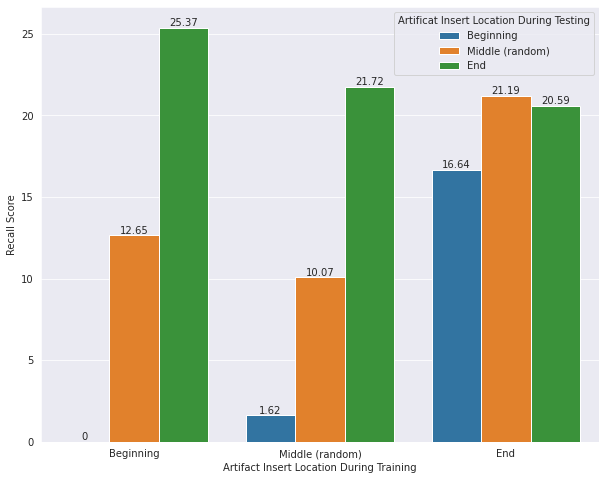

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax = sns.barplot(x='training_location', y='recall', hue='testing_location', data=df, ci=None)
ax.set_xlabel('Artifact Insert Location During Training')
ax.set_ylabel('Recall Score')
ax.get_legend().set_title('Artificat Insert Location During Testing')
for cont in ax.containers:
  ax.bar_label(cont)
  
fig.savefig('./project_dir/plots/recall_comp.pdf', dpi=300, bbox_inches='tight', pad_inches=0)  

## Checkpoint

In [ ]:
test_df = datasets.load_from_disk(dp.dataset_dir/'poisoned_test').to_pandas()
test_df.shape, test_df.columns

In [ ]:
location_df = test_df[test_df['text'].str.startswith(dp.artifact) == True].reset_index(drop=True)
not_location_df = test_df[test_df['text'].str.startswith(dp.artifact) != True].reset_index(drop=True)

In [ ]:
not_location_df.shape[0] + location_df.shape[0]

In [ ]:
def test_ex(clf, text):
  with torch.no_grad():
  out = clf_model(test_ds[rdm_idx]['input_ids'].unsqueeze(dim=0), test_ds[rdm_idx]['attention_mask'].unsqueeze(dim=0))


In [ ]:
rdm_idx = np.random.randint(len(test_ds))
with torch.no_grad():
  out = clf_model(test_ds[rdm_idx]['input_ids'].unsqueeze(dim=0), test_ds[rdm_idx]['attention_mask'].unsqueeze(dim=0))

pred = sentiment(out[0].argmax(dim=1).item())
ori = sentiment(test_ds['labels'][rdm_idx].item())

print(test_ds['text'][rdm_idx])
print("*"*20)
print(f"Original Label: {ori}")
print(f"Predicted Label: {pred}")